## Введение
В этом проекте мы проведём маркетинговый анализ развлекательного приложения `Procrastinate Pro+`. Разберёмся в причинах  сложившейся печальной ситуации: несколько прошлых месяцев бизнес постоянно нес убытки - в привлечение пользователей была вложена куча денег, а толку никакого.

У нас в распоряжении есть лог сервера с данными о посещениях приложения новыми пользователями, зарегистрировавшимися в период с 2019-05-01 по 2019-10-27, выгрузка их покупок за этот период, а также статистика рекламных расходов. 

Мы изучим, как люди пользуются продуктом, когда они начинают покупать, сколько денег приносит каждый клиент, когда он окупается и какие факторы отричательно влияют на привлечение пользователей.

Опишем возможные причины обнаруженных проблем и сформируем рекомендации для рекламного отдела.

Будем считать, что смотрим данные 1-го ноября 2019 года и что окупаемость должна наступать не позднее, чем через 2 недели после привлечения пользователей.


### Описание данных
Таблица visits_log_short (лог сервера с информацией о посещениях сайта):

    User Id — уникальный идентификатор пользователя
    Device — категория устройства пользователя
    Session start — дата и время начала сессии
    Session End — дата и время окончания сессии
    Channel — идентификатор рекламного источника, из которого пришел пользователь
    Region - страна пользователя

Таблица orders_log_short (информация о заказах):

    User Id — уникальный id пользователя, который сделал заказ
    Event Dt — дата и время покупки
    Revenue — выручка

Таблица costs_short (информация о затратах на маркетинг):

    Channel — идентификатор рекламного источника
    Dt — дата
    Costs — затраты на этот рекламный источник в этот день

## Загружаем данные и подготовим их к анализу

In [1]:
# Подключаем нужные библиотеки

import os
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
from matplotlib import pyplot as plt
from termcolor import colored
import seaborn as sns

In [2]:
# Моя собственная функция для первичного анализа загружаемых таблиц

def base_info(df):
    df.columns = [col.lower().replace(' ','_').replace('-','_') for col in df.columns]
    print(colored("Общая информация о таблице:", "blue", attrs=['bold']))
    print()
    print(df.info())
    print()
    print(colored("Циферки:", "blue", attrs=['bold']))
    display(df.describe().T)
    print()
    print(colored("Количество явных дубликатов: ", "blue", attrs=['bold']), df.duplicated().sum())
    print()
    print(colored("Первые строки таблицы:", "blue", attrs=['bold']))
    display(df.head())
    print(colored("Доли отсутствующих значений", "blue", attrs=['bold']))
    print(round(df.isna().sum() * 100 / len(df), 2))

### Загрузка таблиц 

In [3]:
# если работаем на ЯП
pth11 = '/datasets/visits_info_short.csv' 
pth12 = '/datasets/orders_info_short.csv' 
pth13 = '/datasets/costs_info_short.csv' 

# если работаем локально
pth21 = 'visits_info_short.csv' 
pth22 = 'orders_info_short.csv' 
pth23 = 'costs_info_short.csv'


if os.path.exists(pth11):
    visits = pd.read_csv(pth11)
    orders = pd.read_csv(pth12)
    costs = pd.read_csv(pth13)
    
elif os.path.exists(pth21):
    visits = pd.read_csv(pth21)
    orders = pd.read_csv(pth22)
    costs = pd.read_csv(pth23)
else:
    print('Что-то поломалось :(')  

In [4]:
base_info(visits)

Общая информация о таблице:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 309901 entries, 0 to 309900
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   user_id        309901 non-null  int64 
 1   region         309901 non-null  object
 2   device         309901 non-null  object
 3   channel        309901 non-null  object
 4   session_start  309901 non-null  object
 5   session_end    309901 non-null  object
dtypes: int64(1), object(5)
memory usage: 14.2+ MB
None

Циферки:


,count,mean,std,min,25%,50%,75%,max
user_id,309901.0,4.997664e+11,2.887899e+11,599326.0,2.493691e+11,4.989906e+11,7.495211e+11,9.999996e+11



Количество явных дубликатов:  0

Первые строки таблицы:


,user_id,region,device,channel,session_start,session_end
0,981449118918,United States,iPhone,organic,2019-05-01 02:36:01,2019-05-01 02:45:01
1,278965908054,United States,iPhone,organic,2019-05-01 04:46:31,2019-05-01 04:47:35
2,590706206550,United States,Mac,organic,2019-05-01 14:09:25,2019-05-01 15:32:08
3,326433527971,United States,Android,TipTop,2019-05-01 00:29:59,2019-05-01 00:54:25
4,349773784594,United States,Mac,organic,2019-05-01 03:33:35,2019-05-01 03:57:40


Доли отсутствующих значений
user_id          0.0
region           0.0
device           0.0
channel          0.0
session_start    0.0
session_end      0.0
dtype: float64


In [5]:
base_info(orders)

Общая информация о таблице:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40212 entries, 0 to 40211
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   user_id   40212 non-null  int64  
 1   event_dt  40212 non-null  object 
 2   revenue   40212 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 942.6+ KB
None

Циферки:


,count,mean,std,min,25%,50%,75%,max
user_id,40212.0,4.990295e+11,2.860937e+11,599326.00,2.511324e+11,4.982840e+11,7.433327e+11,9.998954e+11
revenue,40212.0,5.370608e+00,3.454208e+00,4.99,4.990000e+00,4.990000e+00,4.990000e+00,4.999000e+01



Количество явных дубликатов:  0

Первые строки таблицы:


,user_id,event_dt,revenue
0,188246423999,2019-05-01 23:09:52,4.99
1,174361394180,2019-05-01 12:24:04,4.99
2,529610067795,2019-05-01 11:34:04,4.99
3,319939546352,2019-05-01 15:34:40,4.99
4,366000285810,2019-05-01 13:59:51,4.99


Доли отсутствующих значений
user_id     0.0
event_dt    0.0
revenue     0.0
dtype: float64


In [6]:
base_info(costs)

Общая информация о таблице:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1800 entries, 0 to 1799
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   dt       1800 non-null   object 
 1   channel  1800 non-null   object 
 2   costs    1800 non-null   float64
dtypes: float64(1), object(2)
memory usage: 42.3+ KB
None

Циферки:


,count,mean,std,min,25%,50%,75%,max
costs,1800.0,58.609611,107.740223,0.8,6.495,12.285,33.6,630.0



Количество явных дубликатов:  0

Первые строки таблицы:


,dt,channel,costs
0,2019-05-01,FaceBoom,113.3
1,2019-05-02,FaceBoom,78.1
2,2019-05-03,FaceBoom,85.8
3,2019-05-04,FaceBoom,136.4
4,2019-05-05,FaceBoom,122.1


Доли отсутствующих значений
dt         0.0
channel    0.0
costs      0.0
dtype: float64


### Приведение типов данных

У нас во всех таблицах столбцы времени/даты имеют тип `object`

In [7]:
visits['session_start'] = pd.to_datetime(visits['session_start'])
visits['session_end'] = pd.to_datetime(visits['session_end'])
orders['event_dt'] = pd.to_datetime(orders['event_dt'])
costs['dt'] = pd.to_datetime(costs['dt']).dt.date

## Задаём функции для расчета и анализа LTV, ROI, удержания и конверсии

### функция для создания пользовательских профилей `get_profiles()`

In [8]:
# функция для создания пользовательских профилей

def get_profiles(sessions, orders, events, ad_costs, event_names=[]):

    # находим параметры первых посещений
    profiles = (
        sessions.sort_values(by=['user_id', 'session_start'])
        .groupby('user_id')
        .agg(
            {
                'session_start': 'first',
                'channel': 'first',
                'device': 'first',
                'region': 'first',
            }
        )
        .rename(columns={'session_start': 'first_ts'})
        .reset_index()
    )

    # для когортного анализа определяем дату первого посещения
    # и первый день месяца, в который это посещение произошло
    profiles['dt'] = profiles['first_ts'].dt.date
    profiles['month'] = profiles['first_ts'].astype('datetime64[M]')

    # добавляем признак платящих пользователей
    profiles['payer'] = profiles['user_id'].isin(orders['user_id'].unique())

    # добавляем флаги для всех событий из event_names
    for event in event_names:
        if event in events['event_name'].unique():
            profiles[event] = profiles['user_id'].isin(
                events.query('event_name == @event')['user_id'].unique()
            )

    # считаем количество уникальных пользователей
    # с одинаковыми источником и датой привлечения
    new_users = (
        profiles.groupby(['dt', 'channel'])
        .agg({'user_id': 'nunique'})
        .rename(columns={'user_id': 'unique_users'})
        .reset_index()
    )

    # объединяем траты на рекламу и число привлечённых пользователей
    ad_costs = ad_costs.merge(new_users, on=['dt', 'channel'], how='left')

    # делим рекламные расходы на число привлечённых пользователей
    ad_costs['acquisition_cost'] = ad_costs['costs'] / ad_costs['unique_users']

    # добавляем стоимость привлечения в профили
    profiles = profiles.merge(
        ad_costs[['dt', 'channel', 'acquisition_cost']],
        on=['dt', 'channel'],
        how='left',
    )

    # стоимость привлечения органических пользователей равна нулю
    profiles['acquisition_cost'] = profiles['acquisition_cost'].fillna(0)

    return profiles

### функция для расчёта удержания `get_retention()`

In [9]:
# функция для расчёта удержания

def get_retention(
    profiles,
    sessions,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # добавляем столбец payer в передаваемый dimensions список
    dimensions = ['payer'] + dimensions

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')

    # собираем «сырые» данные для расчёта удержания
    result_raw = result_raw.merge(
        sessions[['user_id', 'session_start']], on='user_id', how='left'
    )
    result_raw['lifetime'] = (
        result_raw['session_start'] - result_raw['first_ts']
    ).dt.days

    # функция для группировки таблицы по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        result = df.pivot_table(
            index=dims, columns='lifetime', values='user_id', aggfunc='nunique'
        )
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        result = result.div(result['cohort_size'], axis=0)
        result = result[['cohort_size'] + list(range(horizon_days))]
        result['cohort_size'] = cohort_sizes
        return result

    # получаем таблицу удержания
    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)

    # получаем таблицу динамики удержания
    result_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    # возвращаем обе таблицы и сырые данные
    return result_raw, result_grouped, result_in_time

### функция для расчёта конверсии `get_conversion()`

In [10]:
# функция для расчёта конверсии

def get_conversion(
    profiles,
    purchases,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')

    # определяем дату и время первой покупки для каждого пользователя
    first_purchases = (
        purchases.sort_values(by=['user_id', 'event_dt'])
        .groupby('user_id')
        .agg({'event_dt': 'first'})
        .reset_index()
    )

    # добавляем данные о покупках в профили
    result_raw = result_raw.merge(
        first_purchases[['user_id', 'event_dt']], on='user_id', how='left'
    )

    # рассчитываем лайфтайм для каждой покупки
    result_raw['lifetime'] = (
        result_raw['event_dt'] - result_raw['first_ts']
    ).dt.days

    # группируем по cohort, если в dimensions ничего нет
    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users' 
        dimensions = dimensions + ['cohort']

    # функция для группировки таблицы по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        result = df.pivot_table(
            index=dims, columns='lifetime', values='user_id', aggfunc='nunique'
        )
        result = result.fillna(0).cumsum(axis = 1)
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        # делим каждую «ячейку» в строке на размер когорты
        # и получаем conversion rate
        result = result.div(result['cohort_size'], axis=0)
        result = result[['cohort_size'] + list(range(horizon_days))]
        result['cohort_size'] = cohort_sizes
        return result

    # получаем таблицу конверсии
    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)

    # для таблицы динамики конверсии убираем 'cohort' из dimensions
    if 'cohort' in dimensions: 
        dimensions = []

    # получаем таблицу динамики конверсии
    result_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    # возвращаем обе таблицы и сырые данные
    return result_raw, result_grouped, result_in_time

### функция для расчёта LTV и ROI `get_ltv()`

In [11]:
# функция для расчёта LTV и ROI

def get_ltv(
    profiles,
    purchases,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')
    # добавляем данные о покупках в профили
    result_raw = result_raw.merge(
        purchases[['user_id', 'event_dt', 'revenue']], on='user_id', how='left'
    )
    # рассчитываем лайфтайм пользователя для каждой покупки
    result_raw['lifetime'] = (
        result_raw['event_dt'] - result_raw['first_ts']
    ).dt.days
    # группируем по cohort, если в dimensions ничего нет
    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users'
        dimensions = dimensions + ['cohort']

    # функция группировки по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        # строим «треугольную» таблицу выручки
        result = df.pivot_table(
            index=dims, columns='lifetime', values='revenue', aggfunc='sum'
        )
        # находим сумму выручки с накоплением
        result = result.fillna(0).cumsum(axis=1)
        # вычисляем размеры когорт
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        # объединяем размеры когорт и таблицу выручки
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        # считаем LTV: делим каждую «ячейку» в строке на размер когорты
        result = result.div(result['cohort_size'], axis=0)
        # исключаем все лайфтаймы, превышающие горизонт анализа
        result = result[['cohort_size'] + list(range(horizon_days))]
        # восстанавливаем размеры когорт
        result['cohort_size'] = cohort_sizes

        # собираем датафрейм с данными пользователей и значениями CAC, 
        # добавляя параметры из dimensions
        cac = df[['user_id', 'acquisition_cost'] + dims].drop_duplicates()

        # считаем средний CAC по параметрам из dimensions
        cac = (
            cac.groupby(dims)
            .agg({'acquisition_cost': 'mean'})
            .rename(columns={'acquisition_cost': 'cac'})
        )

        # считаем ROI: делим LTV на CAC
        roi = result.div(cac['cac'], axis=0)

        # удаляем строки с бесконечным ROI
        roi = roi[~roi['cohort_size'].isin([np.inf])]

        # восстанавливаем размеры когорт в таблице ROI
        roi['cohort_size'] = cohort_sizes

        # добавляем CAC в таблицу ROI
        roi['cac'] = cac['cac']

        # в финальной таблице оставляем размеры когорт, CAC
        # и ROI в лайфтаймы, не превышающие горизонт анализа
        roi = roi[['cohort_size', 'cac'] + list(range(horizon_days))]

        # возвращаем таблицы LTV и ROI
        return result, roi

    # получаем таблицы LTV и ROI
    result_grouped, roi_grouped = group_by_dimensions(
        result_raw, dimensions, horizon_days
    )

    # для таблиц динамики убираем 'cohort' из dimensions
    if 'cohort' in dimensions:
        dimensions = []

    # получаем таблицы динамики LTV и ROI
    result_in_time, roi_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    return (
        result_raw,  # сырые данные
        result_grouped,  # таблица LTV
        result_in_time,  # таблица динамики LTV
        roi_grouped,  # таблица ROI
        roi_in_time,  # таблица динамики ROI
    )

### функция для сглаживания фрейма `filter_data()`

In [12]:
# функция для сглаживания фрейма

def filter_data(df, window):
    # для каждого столбца применяем скользящее среднее
    for column in df.columns.values:
        df[column] = df[column].rolling(window).mean() 
    return df

### функция для визуализации удержания `plot_retention()`

In [13]:
# функция для визуализации удержания

def plot_retention(retention, retention_history, horizon, window=7):

    # задаём размер сетки для графиков
    plt.figure(figsize=(15, 10))

    # исключаем размеры когорт и удержание первого дня
    retention = retention.drop(columns=['cohort_size', 0])
    # в таблице динамики оставляем только нужный лайфтайм
    retention_history = retention_history.drop(columns=['cohort_size'])[
        [horizon - 1]
    ]

    # если в индексах таблицы удержания только payer,
    # добавляем второй признак — cohort
    if retention.index.nlevels == 1:
        retention['cohort'] = 'All users'
        retention = retention.reset_index().set_index(['cohort', 'payer'])

    # в таблице графиков — два столбца и две строки, четыре ячейки
    # в первой строим кривые удержания платящих пользователей
    ax1 = plt.subplot(2, 2, 1)
    retention.query('payer == True').droplevel('payer').T.plot(
        grid=True, ax=ax1
    )
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Удержание платящих пользователей')

    # во второй ячейке строим кривые удержания неплатящих
    # вертикальная ось — от графика из первой ячейки
    ax2 = plt.subplot(2, 2, 2, sharey=ax1)
    retention.query('payer == False').droplevel('payer').T.plot(
        grid=True, ax=ax2
    )
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Удержание неплатящих пользователей')

    # в третьей ячейке — динамика удержания платящих
    ax3 = plt.subplot(2, 2, 3)
    # получаем названия столбцов для сводной таблицы
    columns = [
        name
        for name in retention_history.index.names
        if name not in ['dt', 'payer']
    ]
    # фильтруем данные и строим график
    filtered_data = retention_history.query('payer == True').pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax3)
    plt.xlabel('Дата привлечения')
    plt.title(
        'Динамика удержания платящих пользователей на {}-й день'.format(
            horizon
        )
    )

    # в чётвертой ячейке — динамика удержания неплатящих
    ax4 = plt.subplot(2, 2, 4, sharey=ax3)
    # фильтруем данные и строим график
    filtered_data = retention_history.query('payer == False').pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax4)
    plt.xlabel('Дата привлечения')
    plt.title(
        'Динамика удержания неплатящих пользователей на {}-й день'.format(
            horizon
        )
    )
    
    plt.tight_layout()
    plt.show()

### функция для визуализации конверсии `plot_conversion()`

In [14]:
# функция для визуализации конверсии

def plot_conversion(conversion, conversion_history, horizon, window=7):

    # задаём размер сетки для графиков
    plt.figure(figsize=(15, 5))

    # исключаем размеры когорт
    conversion = conversion.drop(columns=['cohort_size'])
    # в таблице динамики оставляем только нужный лайфтайм
    conversion_history = conversion_history.drop(columns=['cohort_size'])[
        [horizon - 1]
    ]

    # первый график — кривые конверсии
    ax1 = plt.subplot(1, 2, 1)
    conversion.T.plot(grid=True, ax=ax1)
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Конверсия пользователей')

    # второй график — динамика конверсии
    ax2 = plt.subplot(1, 2, 2, sharey=ax1)
    columns = [
        # столбцами сводной таблицы станут все столбцы индекса, кроме даты
        name for name in conversion_history.index.names if name not in ['dt']
    ]
    filtered_data = conversion_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax2)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика конверсии пользователей на {}-й день'.format(horizon))

    plt.tight_layout()
    plt.show()

### функция для визуализации LTV и ROI `plot_ltv_roi()`

In [15]:
# функция для визуализации LTV и ROI

def plot_ltv_roi(ltv, ltv_history, roi, roi_history, horizon, window=7):

    # задаём сетку отрисовки графиков
    plt.figure(figsize=(20, 10))

    # из таблицы ltv исключаем размеры когорт
    ltv = ltv.drop(columns=['cohort_size'])
    # в таблице динамики ltv оставляем только нужный лайфтайм
    ltv_history = ltv_history.drop(columns=['cohort_size'])[[horizon - 1]]

    # стоимость привлечения запишем в отдельный фрейм
    cac_history = roi_history[['cac']]

    # из таблицы roi исключаем размеры когорт и cac
    roi = roi.drop(columns=['cohort_size', 'cac'])
    # в таблице динамики roi оставляем только нужный лайфтайм
    roi_history = roi_history.drop(columns=['cohort_size', 'cac'])[
        [horizon - 1]
    ]

    # первый график — кривые ltv
    ax1 = plt.subplot(2, 3, 1)
    ltv.T.plot(grid=True, ax=ax1)
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('LTV')

    # второй график — динамика ltv
    ax2 = plt.subplot(2, 3, 2, sharey=ax1)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in ltv_history.index.names if name not in ['dt']]
    filtered_data = ltv_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax2)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика LTV пользователей на {}-й день'.format(horizon))

    # третий график — динамика cac
    ax3 = plt.subplot(2, 3, 3, sharey=ax1)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in cac_history.index.names if name not in ['dt']]
    filtered_data = cac_history.pivot_table(
        index='dt', columns=columns, values='cac', aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax3)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика стоимости привлечения пользователей')

    # четвёртый график — кривые roi
    ax4 = plt.subplot(2, 3, 4)
    roi.T.plot(grid=True, ax=ax4)
    plt.axhline(y=1, color='red', linestyle='--', label='Уровень окупаемости')
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('ROI')

    # пятый график — динамика roi
    ax5 = plt.subplot(2, 3, 5, sharey=ax4)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in roi_history.index.names if name not in ['dt']]
    filtered_data = roi_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax5)
    plt.axhline(y=1, color='red', linestyle='--', label='Уровень окупаемости')
    plt.xlabel('Дата привлечения')
    plt.title('Динамика ROI пользователей на {}-й день'.format(horizon))

    plt.tight_layout()
    plt.show()

## Исследовательский анализ

### Профили пользователей

Для создания профилей пользователей используем готовую функцию `get_profiles()`

In [16]:
events = None # Раз у нас нет таблицы с событиями, передаём None, чтобы функция не сломалась
profiles = get_profiles(visits, orders, events, costs)
display(profiles.head(5))

,user_id,first_ts,channel,device,region,dt,month,payer,acquisition_cost
0,599326,2019-05-07 20:58:57,FaceBoom,Mac,United States,2019-05-07,2019-05-01,True,1.088172
1,4919697,2019-07-09 12:46:07,FaceBoom,iPhone,United States,2019-07-09,2019-07-01,False,1.107237
2,6085896,2019-10-01 09:58:33,organic,iPhone,France,2019-10-01,2019-10-01,False,0.000000
3,22593348,2019-08-22 21:35:48,AdNonSense,PC,Germany,2019-08-22,2019-08-01,False,0.988235
4,31989216,2019-10-02 00:07:44,YRabbit,iPhone,United States,2019-10-02,2019-10-01,False,0.230769


Пользователи регистрировались в приложении с 2019-05-01 по 2019-10-27, проверим на всякий случай:

In [17]:
profiles_max_min_date=(profiles.sort_values(by=['user_id','first_ts'])
        .groupby('user_id')
        .agg({'first_ts':['first', 'last']})
        .reset_index())
                      
profiles_max_min_date.columns = profiles_max_min_date.columns.get_level_values(1)
profiles_max_min_date.columns = ['user_id', 'first', 'last']

display(profiles_max_min_date['first'].min())
display(profiles_max_min_date['last'].max())
profiles_max_min_date

Timestamp('2019-05-01 00:00:41')

Timestamp('2019-10-27 23:59:04')

,user_id,first,last
0,599326,2019-05-07 20:58:57,2019-05-07 20:58:57
1,4919697,2019-07-09 12:46:07,2019-07-09 12:46:07
2,6085896,2019-10-01 09:58:33,2019-10-01 09:58:33
3,22593348,2019-08-22 21:35:48,2019-08-22 21:35:48
4,31989216,2019-10-02 00:07:44,2019-10-02 00:07:44
...,...,...,...
150003,999956196527,2019-09-28 08:33:02,2019-09-28 08:33:02
150004,999975439887,2019-10-21 00:35:17,2019-10-21 00:35:17
150005,999976332130,2019-07-23 02:57:06,2019-07-23 02:57:06
150006,999979924135,2019-09-28 21:28:09,2019-09-28 21:28:09


Для дальнейшего анализа напишем универсальную функцию группировки и вывода

In [18]:
def user_report(group):
    report = (profiles.groupby(group)
          .agg({'user_id': 'nunique', 'payer': ['sum', 'mean']}))

    report.columns = ['Всего', 'Купили', 'Купили %']
    report = report.sort_values(by='Купили %', ascending=False).style.format({'Купили %': '{:.2%}'})
    return report

### Страны пользователей

Выясним, из каких стран наши пользователи, и кто из них покупает больше

In [19]:
user_report('region')

,Всего,Купили,Купили %
region,,,
United States,100002,6902,6.90%
Germany,14981,616,4.11%
UK,17575,700,3.98%
France,17450,663,3.80%


Больше всего пользователей из США, и доля делающих покупки в приложении тоже.

### Устройства пользователей

In [20]:
user_report('device')

,Всего,Купили,Купили %
device,,,
Mac,30042,1912,6.36%
iPhone,54479,3382,6.21%
Android,35032,2050,5.85%
PC,30455,1537,5.05%


Больше всего приложение используют на IPhone, а вот покупают в процентном отношении лучше пользователи Mac

### Каналы привлечения

In [21]:
user_report('channel')

,Всего,Купили,Купили %
channel,,,
FaceBoom,29144,3557,12.20%
AdNonSense,3880,440,11.34%
lambdaMediaAds,2149,225,10.47%
TipTop,19561,1878,9.60%
RocketSuperAds,4448,352,7.91%
WahooNetBanner,8553,453,5.30%
YRabbit,4312,165,3.83%
MediaTornado,4364,156,3.57%
LeapBob,8553,262,3.06%


А вот тут уже интереснее картина: больше всех наше приложении установили и без рекламы (organic), но вот покупателй всего 2%. Лучше всех показал себя FaceBoom, именно оттуда пришло больше всего пользователей, и сделали болльше всего покупок. 

Вывод:
Хорошая реклама, надо брать :)

### Вывод

Итак: мы посмотрели на базовые значения конверсии пользователей в покупатели по регионам, устройствам и каналу привлечения, определили основной рынок: США, Германия, Великобритания и Франция. Получается, что больше всего приходит пользователей из США и они лучше других конвертируется. При этом большая часть пользователей заходит с мобильных устройств. Также, мы можем сказать, что наибольшую конверсию имеют пользователи, которые пользуются Mac, а затем следуют пользователи iPhone, т.е. мы можем сказать, что в целом пользователи Apple имеют лучшую конверсию в покупателей. Возможно, тут есть плюсы ApplePay. 

А вот с рекламой нужно смотреть: Мы имеем явного лидера по привлечению клиентов, сеть FaceBoom, есть ещё TipTop, который тоже привлекает очень много пользователей. Вот мы в дальнейшем посмотрим, а сколько стоит привлечение пользователей по каждому рекламному каналу.

## Маркетинг

### Общая сумма расходов на маркетинг

У нас есть замечательная таблица `costs`, из неё мы узнаем стоимость нашей рекламы и построим 2 графика: Общих расходов и по каналам привлечения

,costs
channel,
TipTop,54751.30
FaceBoom,32445.60
WahooNetBanner,5151.00
AdNonSense,3911.25
OppleCreativeMedia,2151.25
RocketSuperAds,1833.00
LeapBob,1797.60
lambdaMediaAds,1557.60
MediaTornado,954.48


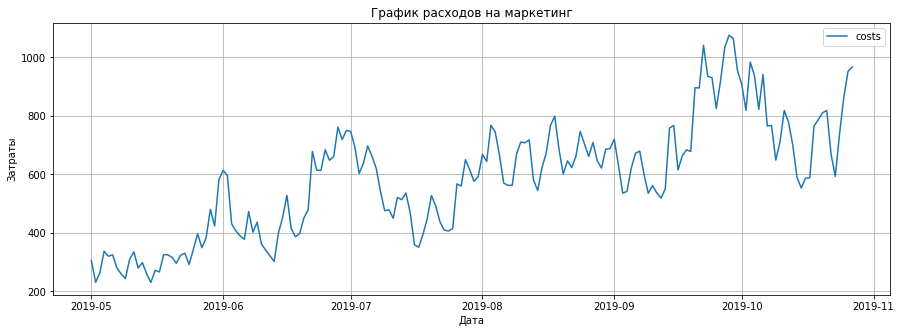

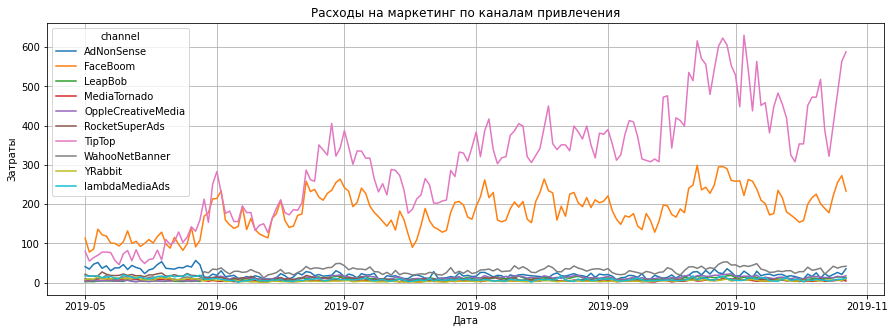

In [22]:
report = (costs.groupby('channel')
          .agg({'costs': 'sum'})
         .sort_values(by='costs', ascending=False))

display(report)

report1 = (costs.groupby('dt').agg({'costs': 'sum'})
          ).plot(grid=True, figsize=(15, 5))
plt.ylabel('Затраты')
plt.xlabel('Дата')
plt.title('График расходов на маркетинг')


costs.pivot_table(
    index='dt', columns='channel', values='costs', aggfunc='mean'
).plot(grid=True, figsize=(15, 5))
plt.ylabel('Затраты')
plt.xlabel('Дата')
plt.title('Расходы на маркетинг по каналам привлечения')
plt.show()

### Распределение трат по источникам

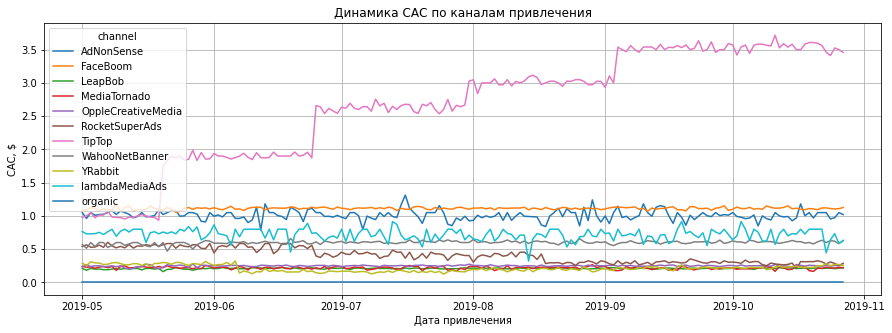

In [23]:
profiles.pivot_table(
    index='dt', columns='channel', values='acquisition_cost', aggfunc='mean'
).plot(grid=True, figsize=(15, 5))
plt.ylabel('CAC, $')
plt.xlabel('Дата привлечения')
plt.title('Динамика САС по каналам привлечения')
plt.show()

А вот и первый растратчик! TipTop обходится всё дороже и дороже! Взглянем на цифры, они врать не станут)))

In [24]:
report = (profiles.groupby('channel')
          .agg({'acquisition_cost': 'mean'})
         .sort_values(by='acquisition_cost', ascending=False))
report

,acquisition_cost
channel,
TipTop,2.799003
FaceBoom,1.113286
AdNonSense,1.008054
lambdaMediaAds,0.724802
WahooNetBanner,0.602245
RocketSuperAds,0.412095
OppleCreativeMedia,0.250000
YRabbit,0.218975
MediaTornado,0.218717


### Вывод

Догадка подтвердилась: у нас есть "Пожиратель бюджета" в виде TipTop! Уж не попиливают ли у нас бюджет? Короткие и смешные видео привлекают нам клиентов, но не за такую же цену! Дальше рассмотрим LTV, поймём, что там к чему..

## Окупаемость рекламы

Отбросим "органиков", так как они пришли бесплатно, их много. Определим горизонт в 14 дней, окупаемость же должна уложиться в 2 недели.

Ответим на вопросы:
- Окупается ли реклама в целом?
- Какие устройства, страны и каналы могут снижать окупаемость рекламы?
- Чем могут быть вызваны проблемы окупаемости?

Опишем возможные причины обнаруженных проблем и дадим рекомендации для рекламного отдела.

In [25]:
observation_date = datetime(2019, 11, 1).date()  # момент анализа
horizon_days = 14  # горизонт анализа 

### Общая окупаемость рекламы
Построим графики LTV и ROI

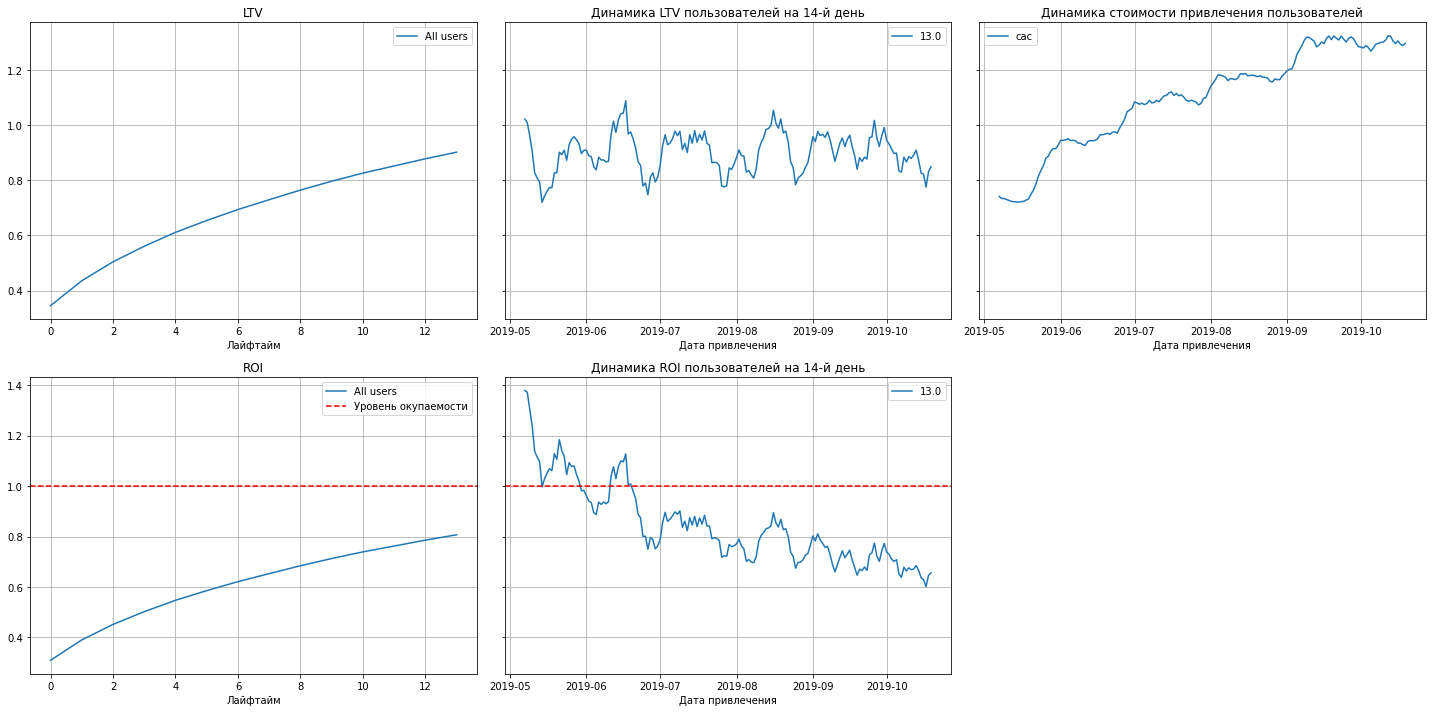

In [26]:
profiles = profiles.query('channel != "organic"')

ltv_raw, ltv, ltv_history, roi, roi_history = get_ltv(
    profiles, orders, observation_date, horizon_days)

plot_ltv_roi(ltv, ltv_history, roi, roi_history, horizon_days)

Видим, что LTV растёт, как и ему и положено. Динамика стоимости привлечения с конца мая месяца резко вырастает. ROI показывает, что на окупаемость мы уже не выходим, причём динамика прям удручает..

### Окупаемость с разбивкой по каналам

Как и договорились, отбросим органиков, чтоб не мешали. А так же понизим "шумность" наших графиков с помощью плавающего среднего

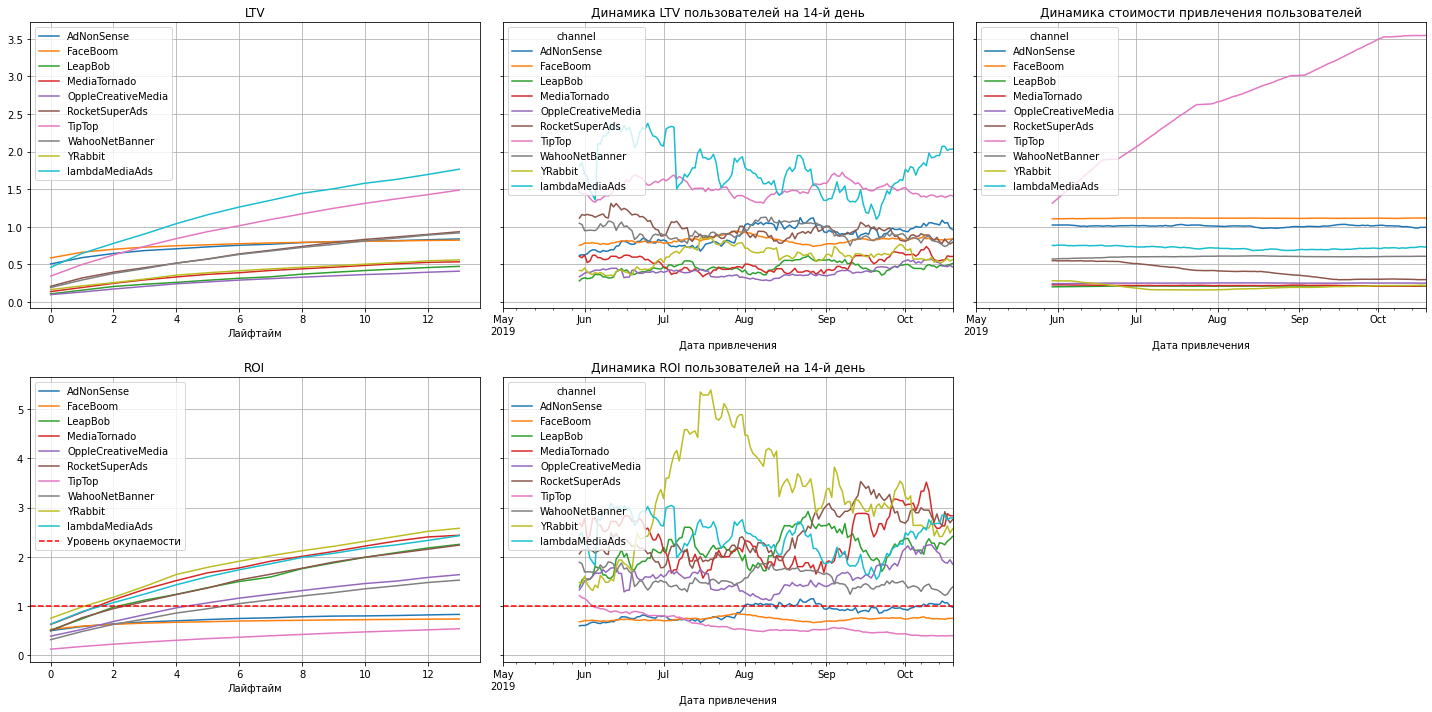

In [27]:
ltv_raw, ltv, ltv_history, roi, roi_history = get_ltv(
    profiles, orders, observation_date, horizon_days, dimensions=['channel']
)

plot_ltv_roi(ltv, ltv_history, roi, roi_history, horizon_days, window = 30)

Видим, что TipTop, FaceBoom и AdNonSense не окупаются, рассмотрим их поближе

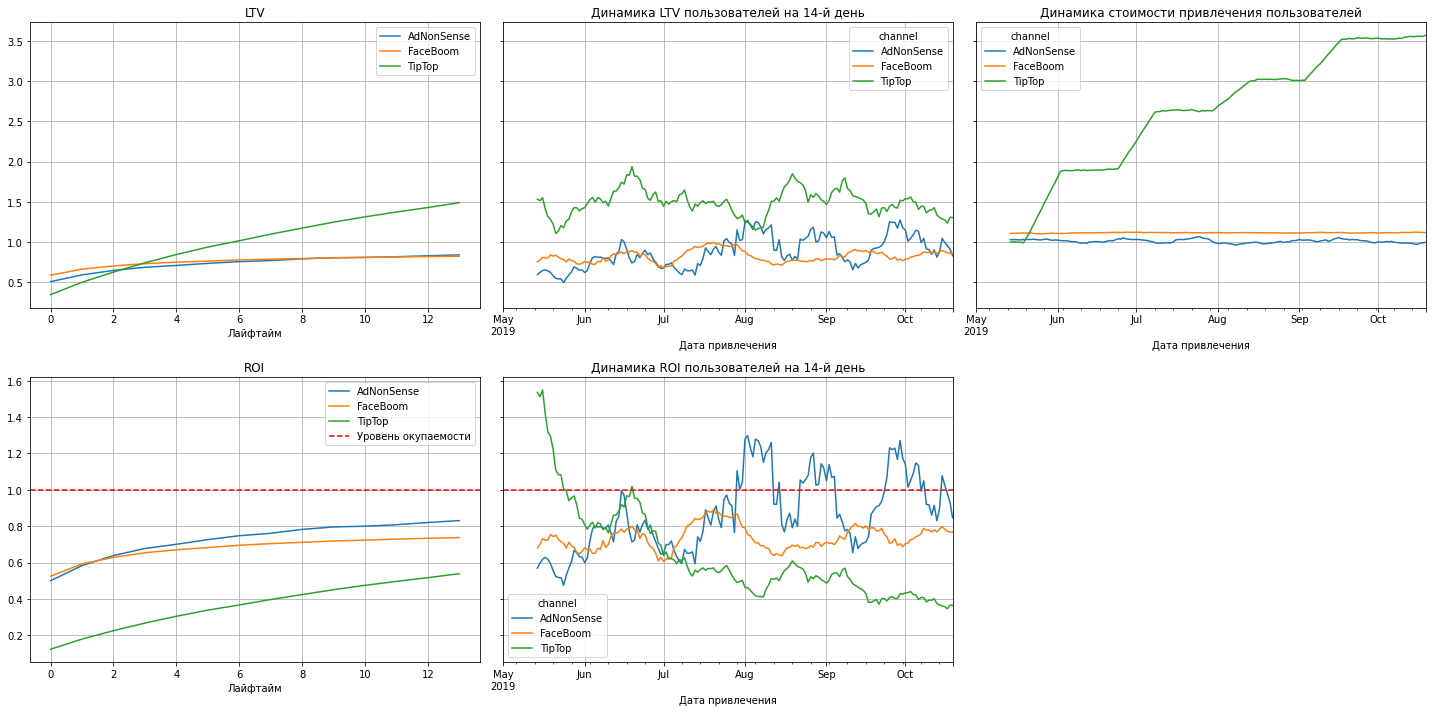

In [28]:
profiles_channels = (
    profiles[(profiles['channel'] == 'TipTop') 
             | (profiles['channel'] == 'FaceBoom')
             | (profiles['channel'] == 'AdNonSense')]
)

ltv_raw, ltv, ltv_history, roi, roi_history = get_ltv(
    profiles_channels, orders, observation_date, horizon_days, dimensions=['channel']
)

plot_ltv_roi(ltv, ltv_history, roi, roi_history, horizon_days, window = 14)

Да, всё верно TipTop нам даёт некачественных пользователей, ведь LTV у них ровненькое, а CAC растёт.. Ну а если числитель тот же, а знаменатель растёт, то такая дробь до единицы уже не доползёт.

### Окупаемость с разбивкой по странам

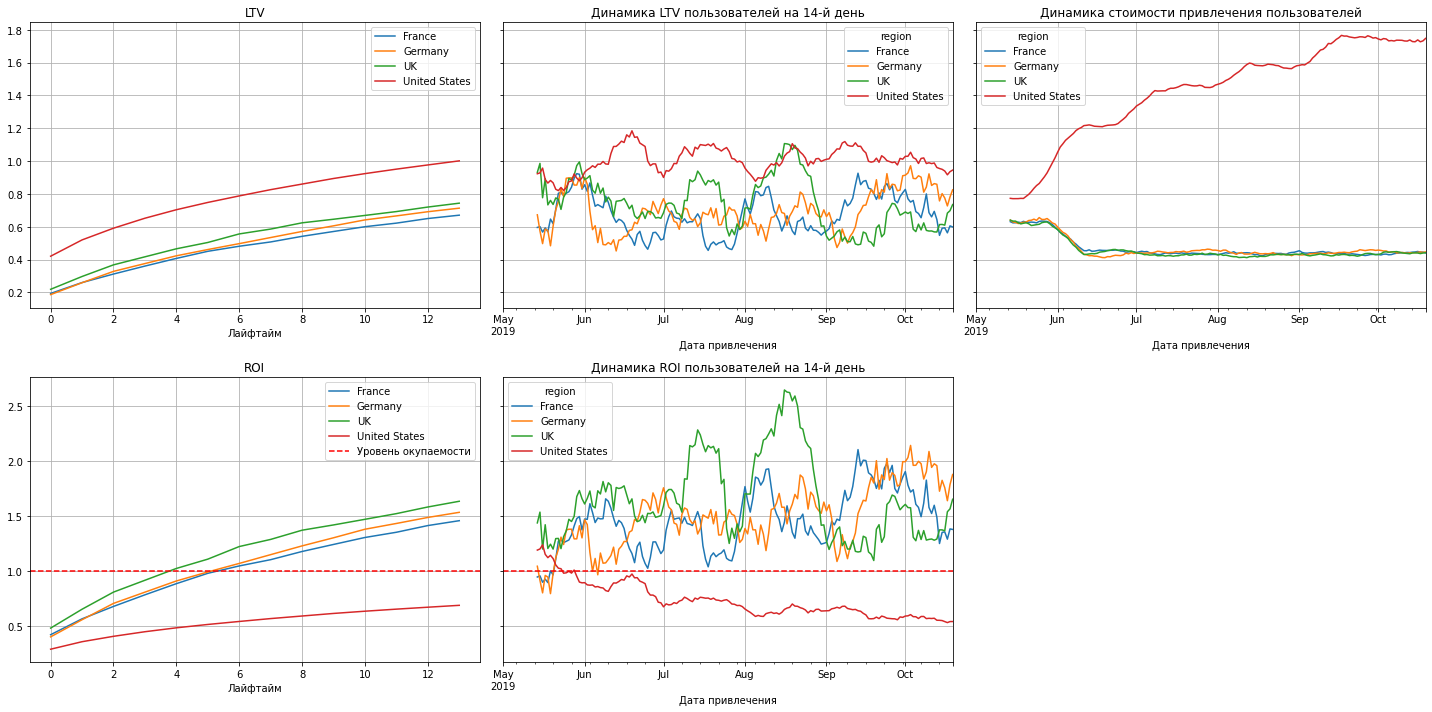

In [29]:
ltv_raw, ltv, ltv_history, roi, roi_history = get_ltv(
    profiles, orders, observation_date, horizon_days, dimensions=['region']
)

plot_ltv_roi(ltv, ltv_history, roi, roi_history, horizon_days, window = 14)

Видим, что у нас совсем не окупается США. Именно там сильно и резко выросла стоимость привлечения клиентов. Остальные страны в порядке.

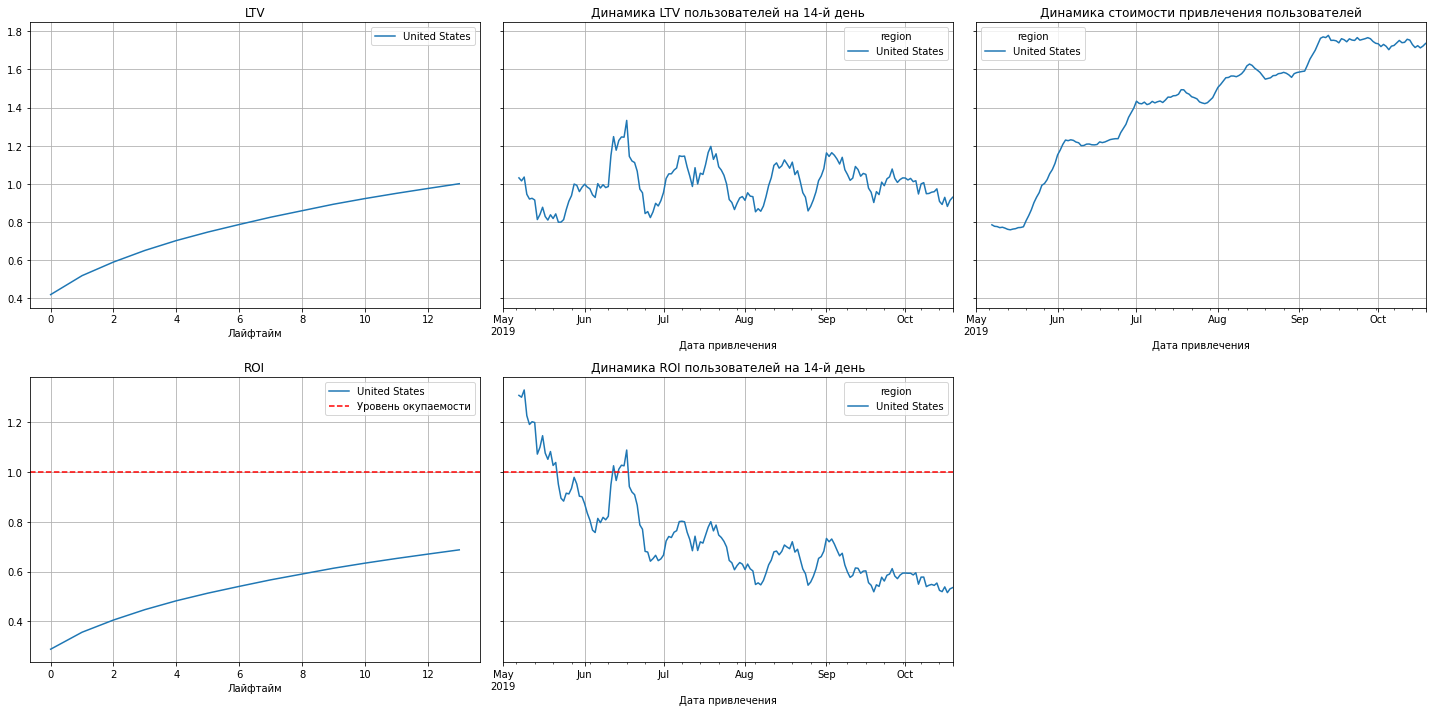

In [30]:
profiles_usa = profiles.query('region == "United States"')
    
ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles_usa, orders, observation_date, horizon_days, dimensions=['region']
)

plot_ltv_roi(ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days)

### Окупаемость по устройствам

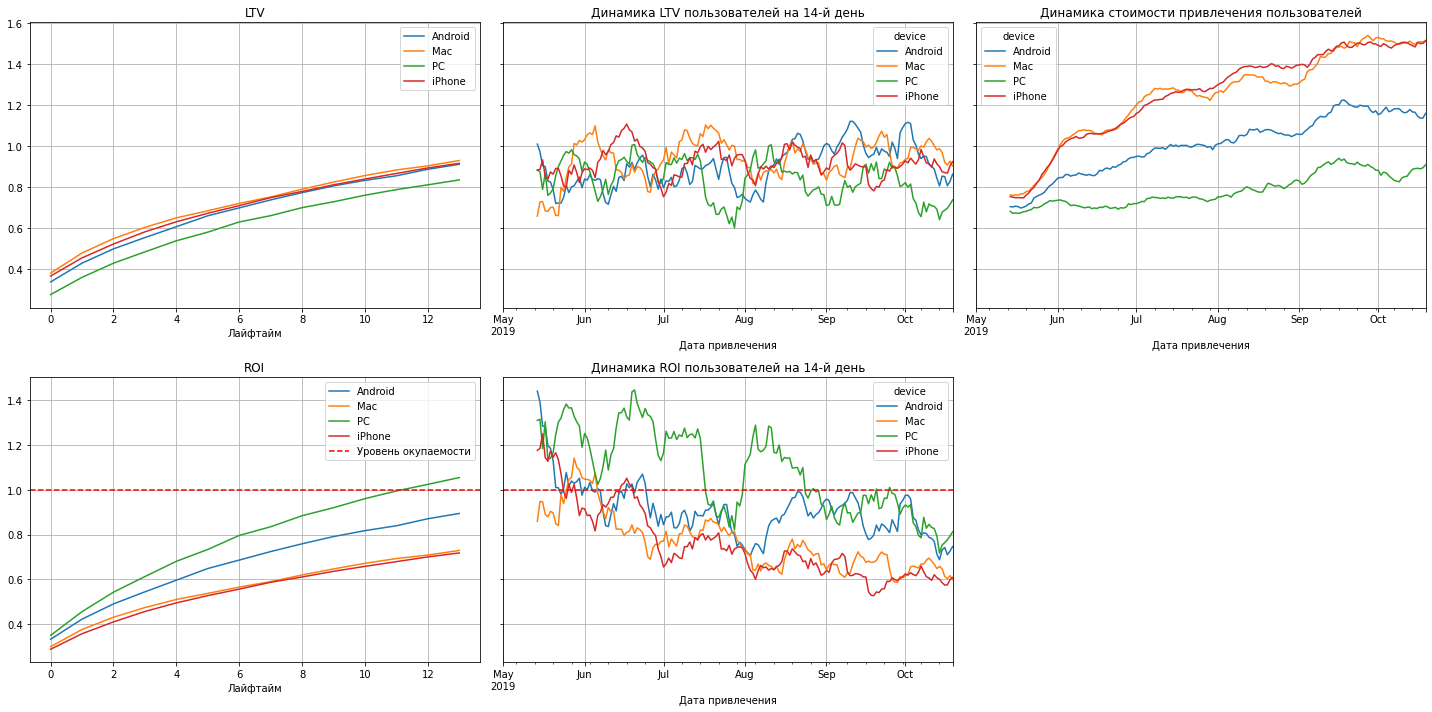

In [31]:
ltv_raw, ltv, ltv_history, roi, roi_history = get_ltv(
    profiles, orders, observation_date, horizon_days, dimensions=['device']
)

plot_ltv_roi(ltv, ltv_history, roi, roi_history, horizon_days, window = 14)

Видим, что из-за более высокой стоимости привлечения на устройствах Apple окупаемость есть только на устройствах PC и Android

### Промежуточный вывод

Итак:
- У нас 3 плохие рекламные сети
- Слишком дорогие привлечение клиентов из США
- Привлечение на Mac и IPhone дороже, и не даёт окупаемости

Последний пункт скорее из-за совокупности первых двух факторов, по нему разница не слишком высокая

### Конверсия и удержание с разбивкой по устройствам

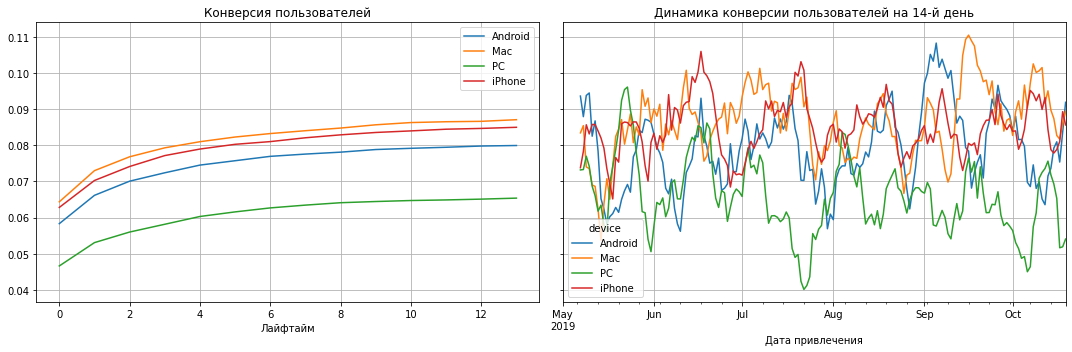

In [32]:
conversion_raw, conversion_grouped, conversion_history = get_conversion(
    profiles, orders, observation_date, horizon_days, dimensions=['device']
)

plot_conversion(conversion_grouped, conversion_history, horizon_days)

По конверсии отстаёт PC

Теперь удержание

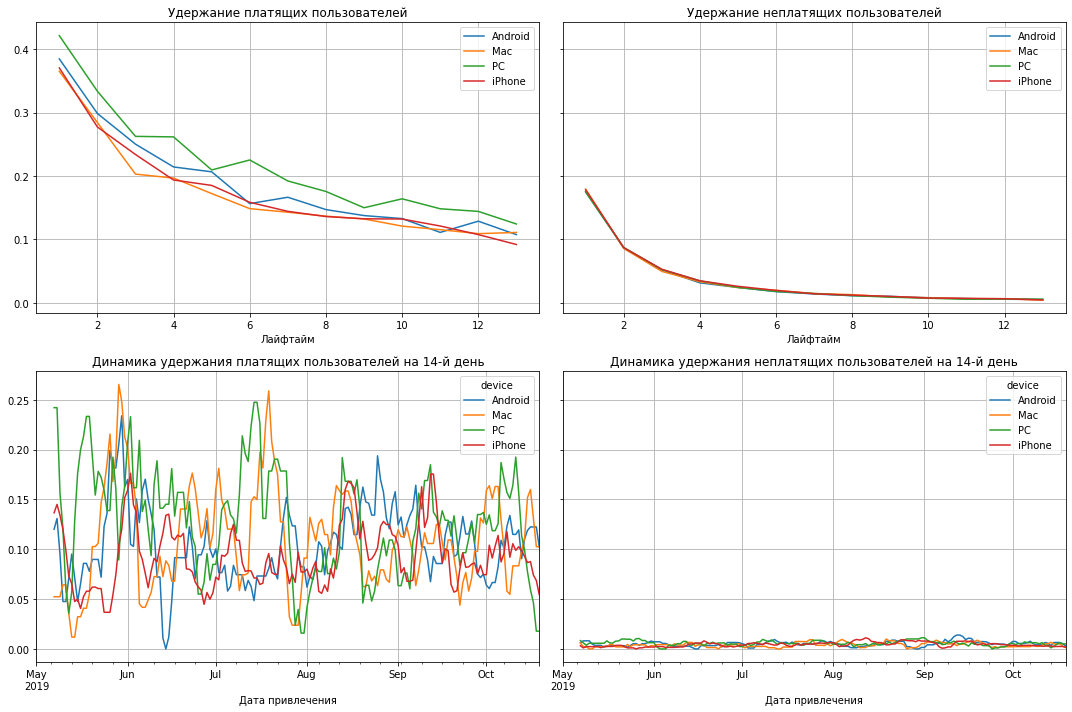

In [33]:
retention_raw, retention_grouped, retention_history = get_retention(
    profiles, visits, observation_date, horizon_days, dimensions=['device']
)

plot_retention(retention_grouped, retention_history, horizon_days)

### Конверсия и удержание с разбивкой по странам

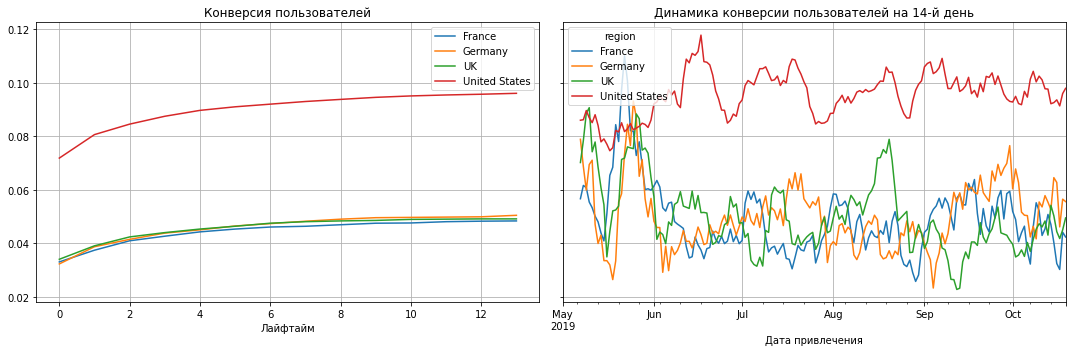

In [34]:
conversion_raw, conversion_grouped, conversion_history = get_conversion(
    profiles, orders, observation_date, horizon_days, dimensions=['region']
)

plot_conversion(conversion_grouped, conversion_history, horizon_days)

Высокая конверсия в США, вот толку маловато

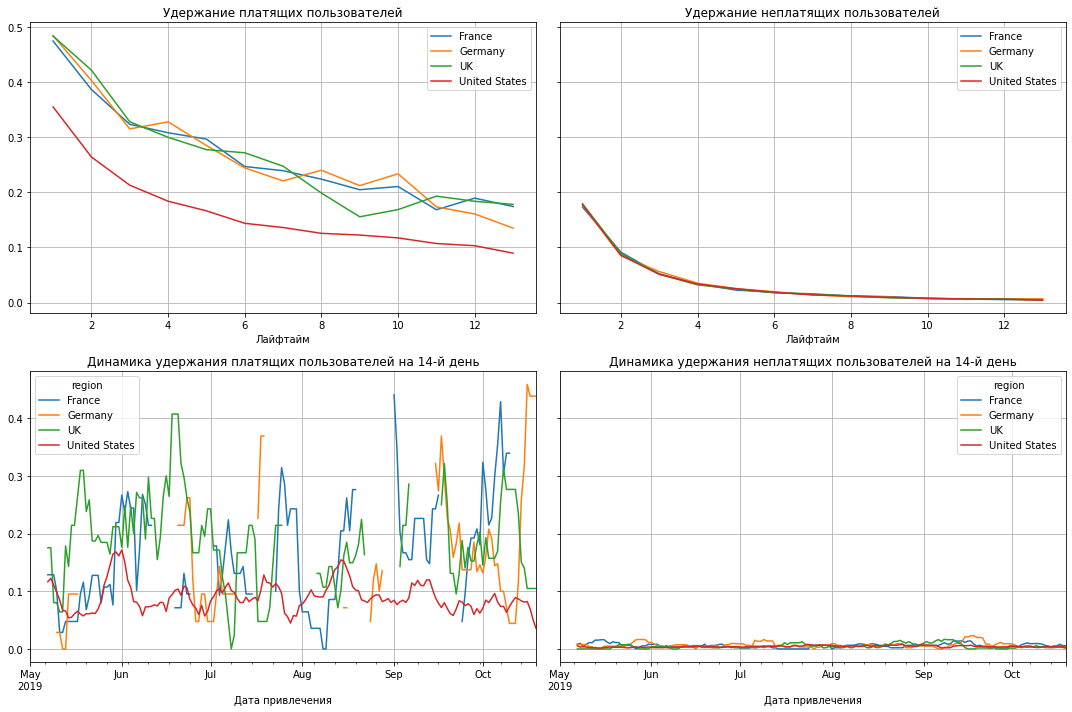

In [35]:
retention_raw, retention_grouped, retention_history = get_retention(
    profiles, visits, observation_date, horizon_days, dimensions=['region']
)

plot_retention(retention_grouped, retention_history, horizon_days)

И как раз видно, что удержание платящих в США ниже всех

### Конверсия и удержание с разбивкой по рекламным каналам

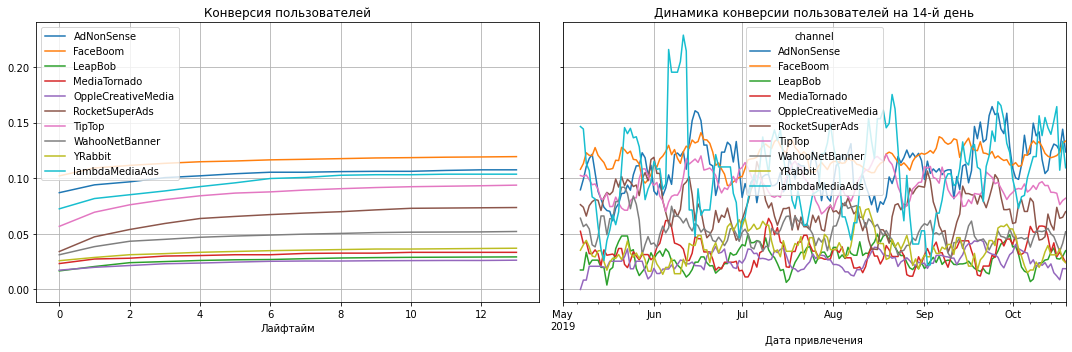

In [36]:
conversion_raw, conversion_grouped, conversion_history = get_conversion(
    profiles, orders, observation_date, horizon_days, dimensions=['channel']
)

plot_conversion(conversion_grouped, conversion_history, horizon_days)

Ну видно, что у тройки самых дорогих реклам высокая конверсия

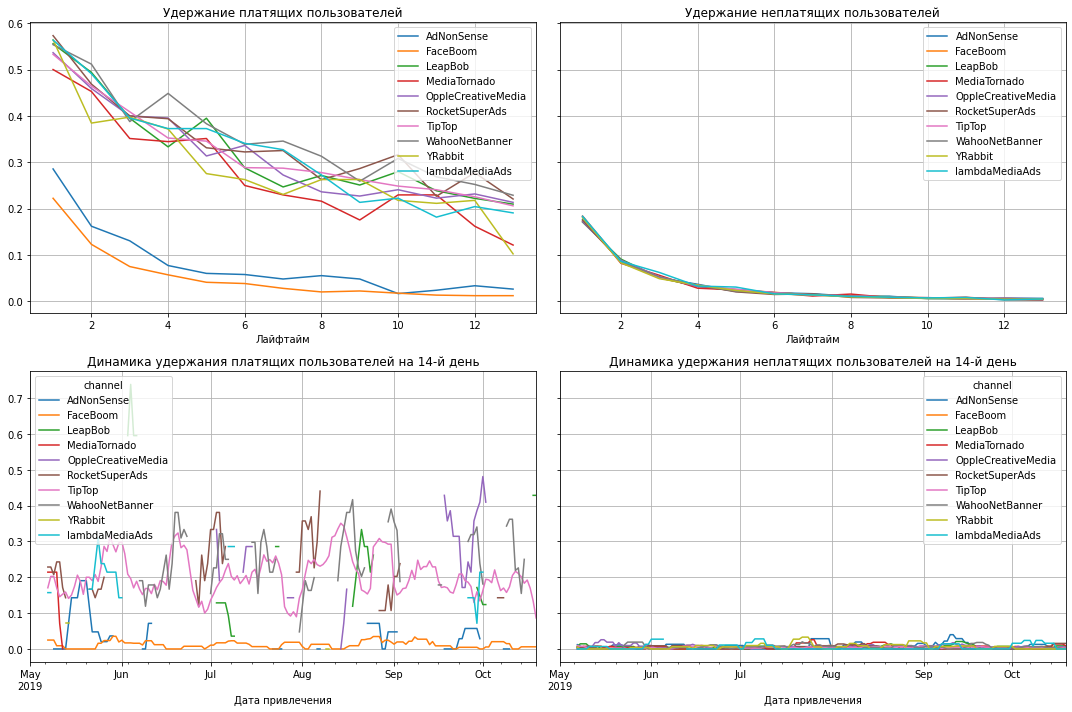

In [37]:
retention_raw, retention_grouped, retention_history = get_retention(
    profiles, visits, observation_date, horizon_days, dimensions=['channel']
)

plot_retention(retention_grouped, retention_history, horizon_days)

А тут видно, что у двух из трёх "наших лидеров рекламы" самое низкое удержание платящих

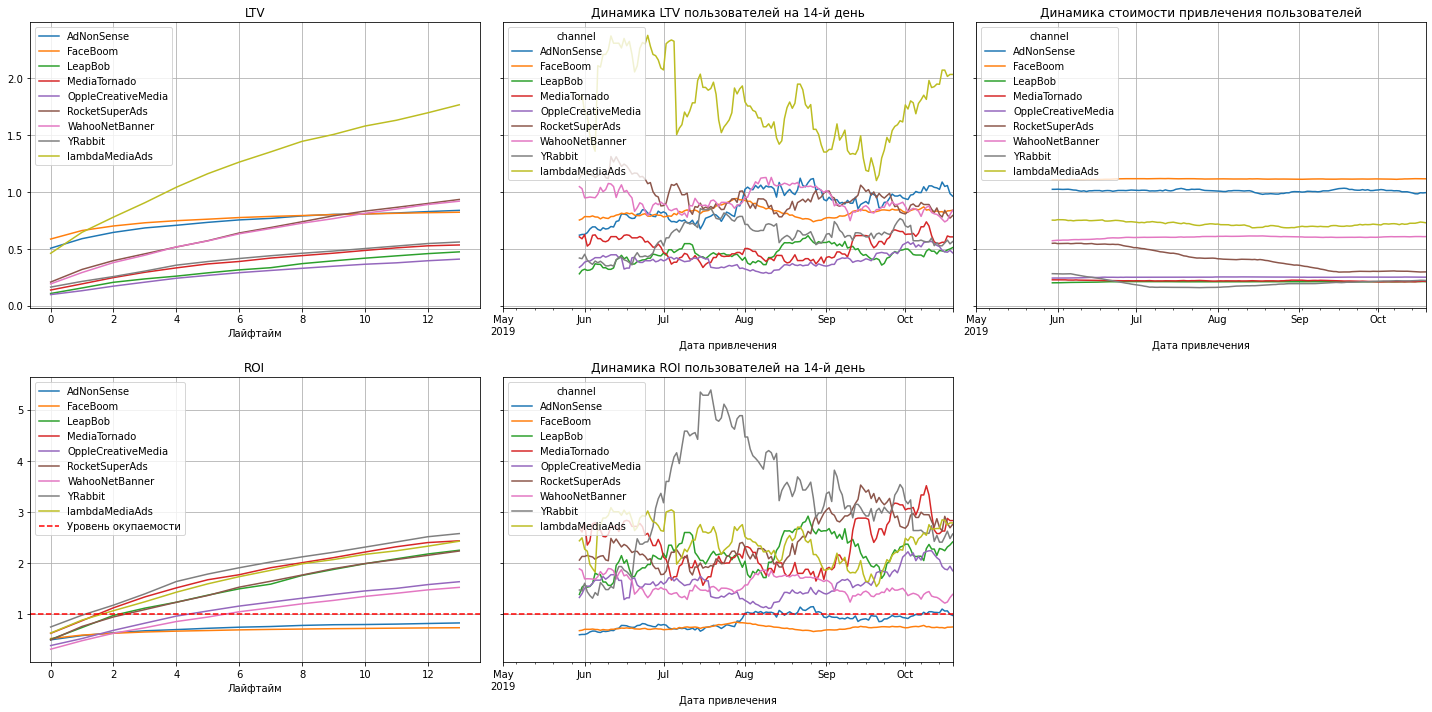

In [38]:
profiles = profiles.query('channel != "organic" & channel != "TipTop"')

ltv_raw, ltv, ltv_history, roi, roi_history = get_ltv(
    profiles, orders, observation_date, horizon_days, dimensions=['channel']
)

plot_ltv_roi(ltv, ltv_history, roi, roi_history, horizon_days, window = 30)

### Вывод

Вот этот кусок исследования показал, что ТОП-3 рекламных кампаний в США работают на показатель конверсии, в реальности они нам денег не приносят, а только разоряют.

## Вывод

По итогу всего исследования я вижу, что наши маркетологи могут похвастаться только высокой конверсией дорогой рекламы. В США приложение просто не окупается. 

Необходимо пересмотреть вложения в рекламу в США, особенно в рекламные сети `FaceBoom`, `TipTop` и  `AdNonSense`. Возможно там мы закупаем рекламу по невыгодной модели, например `CPA`, при которой пользователи устанавливают наше приложение, но ничего в нём не покупают.

Стоит рассмотреть тот же `LambdaMediaAds`, как более перспективный канал

А ещё стоит рассмотреть другие рынки, например ту же Россию, ох у нас тут прокрастинирвать-то любят!